In [192]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
sns.palplot(sns.color_palette())
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from collections import Counter
import os
print(os.listdir("../input"))
# plotly standard imports
import plotly.graph_objs as go
import plotly.plotly as py
# Cufflinks wrapper on plotly
import cufflinks as cf
%matplotlib inline
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)
cf.go_offline(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
# Set global theme
cf.set_config_file(world_readable=True, theme='pearl')
# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# Fetch Data and Explore

In [141]:
train=pd.read_csv("../input/train.csv")
test=pd.read_csv("../input/test.csv")

dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
train = text_to_dict(train)
test = text_to_dict(test)

In [143]:
train.release_date.head()

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
Name: release_date, dtype: object

In [ ]:
train.head(3)

In [144]:
#Lets check at the basic information about our data
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    3000 non-null object
budget                   3000 non-null int64
genres                   3000 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     3000 non-null object
production_countries     3000 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         3000 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords            

In [145]:
#Lets check the basic overview of our numeric data 
print("Shape of train data ",train.shape , "\nShape of test data ",test.shape )

train.describe()

Shape of train data  (3000, 23) 
Shape of test data  (4398, 22)


,id,budget,popularity,runtime,revenue
count,3000.000000,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,1500.500000,2.253133e+07,8.463274,107.856571,6.672585e+07
std,866.169729,3.702609e+07,12.104000,22.086434,1.375323e+08
min,1.000000,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,750.750000,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,1500.500000,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2250.250000,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3000.000000,3.800000e+08,294.337037,338.000000,1.519558e+09


# Check Missing Data

In [146]:
#Lets check how many columns have null value in it

null_columns=train.columns[train.isnull().any()]

train[null_columns].isnull().sum()

homepage       2054
overview          8
poster_path       1
runtime           2
tagline         597
dtype: int64

             Missing Ratio
homepage         68.466667
tagline          19.900000
overview          0.266667
runtime           0.066667
poster_path       0.033333


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Percent of missing values')

Text(0.5, 1.0, 'Percent missing data by feature')

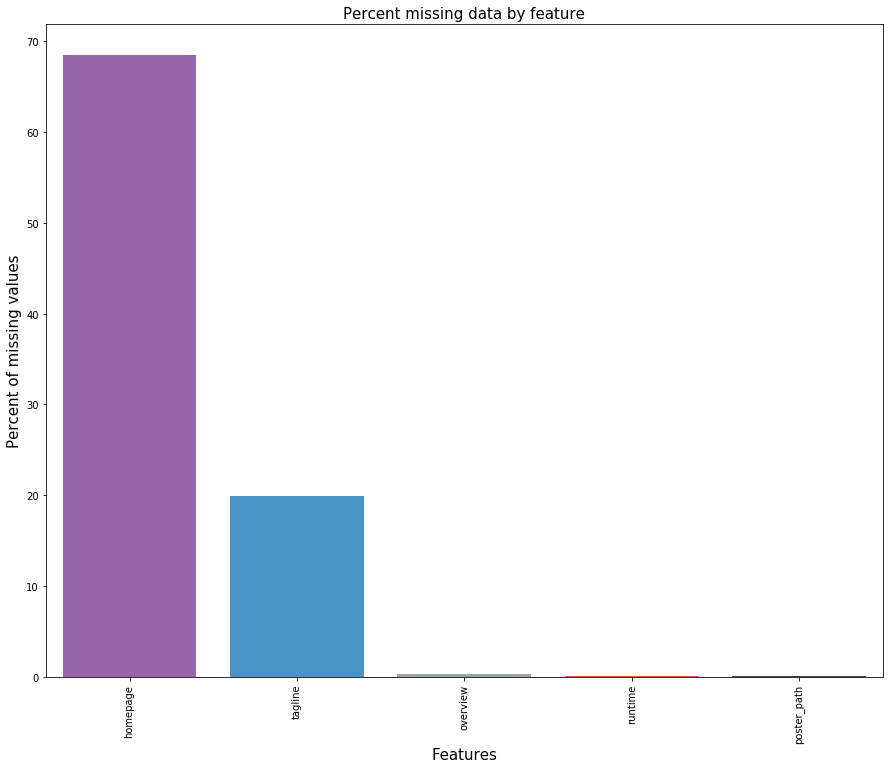

In [147]:
#Lets draw the same 
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
print(missing_data.head(20))
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index.values, y=missing_data["Missing Ratio"])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

# Handling Ecah Column Seperately

**belongs_to_collection**

In [148]:
train['belongs_to_collection'][0]

[{'id': 313576,
  'name': 'Hot Tub Time Machine Collection',
  'poster_path': '/iEhb00TGPucF0b4joM1ieyY026U.jpg',
  'backdrop_path': '/noeTVcgpBiD48fDjFVic1Vz7ope.jpg'}]

In [149]:
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
test['collection_name'] = test['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)

**Genre**

In [150]:
train['num_genres'] = train['genres'].apply(lambda x: len(x) if x != {} else 0)
train['all_genres'] = train['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')


In [151]:
list_of_genres = list(train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

In [152]:
# basically counter gives count for each genre most_common() order it from high to low ...

Counter([i for j in list_of_genres for i in j]).most_common() 
#We can see that there are overall 20 genres 
#Lets see if any particular movie is from the most popular genre for this purpose lets take top 10 genre 
top_genre=Counter([i for j in list_of_genres for i in j]).most_common()[:10]
#print(top_genre)
#lets only the genre name
top_genre=[i[0] for i in top_genre]
print(top_genre)
for g in top_genre:
    train['genre_' + g] = train['all_genres'].apply(lambda x: 1 if g in x else 0)
#Similary we will do for other columns as well

[('Drama', 1531),
 ('Comedy', 1028),
 ('Thriller', 789),
 ('Action', 741),
 ('Romance', 571),
 ('Crime', 469),
 ('Adventure', 439),
 ('Horror', 301),
 ('Science Fiction', 290),
 ('Family', 260),
 ('Fantasy', 232),
 ('Mystery', 225),
 ('Animation', 141),
 ('History', 132),
 ('Music', 100),
 ('War', 100),
 ('Documentary', 87),
 ('Western', 43),
 ('Foreign', 31),
 ('TV Movie', 1)]

['Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime', 'Adventure', 'Horror', 'Science Fiction', 'Family']


**Languages**

In [153]:
train['num_lang'] = train['spoken_languages'].apply(lambda x: len(x) if x != {} else 0)
train['all_lang'] = train['spoken_languages'].apply(lambda x: ' '.join(sorted([i['iso_639_1'] for i in x])) if x != {} else '')


In [154]:
list_of_lang = list(train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_lang[:10])

[['English'], ['English'], ['English'], ['English', 'हिन्दी'], ['한국어/조선말'], ['English'], ['English'], ['العربية', 'English'], ['English'], ['English']]


In [155]:

print("Total languages ",len(Counter([i for j in list_of_lang for i in j]).most_common() ))
#here we have approximately 56 langauges so we can consider may be top 20 as popular languages

top_lang=Counter([i for j in list_of_lang for i in j]).most_common()[:20]
#print(top_genre)
#lets only the genre name
top_lang=[i[0] for i in top_lang]
print(top_lang)
for g in top_lang:
    train['lang_' + g] = train['all_lang'].apply(lambda x: 1 if g in x else 0)
#Similary we will do for other columns as well

Total languages  56
['English', 'Français', 'Español', 'Deutsch', 'Pусский', 'Italiano', '日本語', '普通话', 'हिन्दी', '', 'Português', 'العربية', '한국어/조선말', '广州话 / 廣州話', 'தமிழ்', 'Polski', 'Magyar', 'Latin', 'svenska', 'ภาษาไทย']


**Production Country**

In [156]:
train['num_pcount'] = train['production_countries'].apply(lambda x: len(x) if x != {} else 0)
train['all_pcount'] = train['production_countries'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')


In [157]:
list_of_prod_country = list(train['production_countries'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_prod_country[:10])

[['United States of America'], ['United States of America'], ['United States of America'], ['India'], ['South Korea'], [], ['United States of America', 'Canada'], [], ['United States of America'], ['United States of America']]


In [159]:
print("Lets check how many Countries are there in totel ",len(Counter([i for j in list_of_prod_country for i in j]).most_common()
                                                                        ))

#Since we have in total 3695 ocmpanies lets check if a particular movies is produced by any of the top 50 companies

top_pcount=Counter([i for j in list_of_prod_country for i in j]).most_common()[:30]
top_pcount=[i[0] for i in top_pcount]
print(top_pcount[:20])

for g in top_pcount:
    train['pcount_' + g] = train['all_pcount'].apply(lambda x: 1 if g in x else 0)


Lets check how many Countries are there in totel  74
['United States of America', 'United Kingdom', 'France', 'Germany', 'Canada', 'India', 'Italy', 'Japan', 'Australia', 'Russia', 'Spain', 'China', 'Hong Kong', 'Ireland', 'Belgium', 'South Korea', 'Mexico', 'Sweden', 'New Zealand', 'Netherlands']


> **production_companies**

In [160]:
train['num_pc'] = train['production_companies'].apply(lambda x: len(x) if x != {} else 0)
train['all_pc'] = train['production_companies'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

In [161]:
list_of_companies = list(train['production_companies'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_lang[:10])

[['English'], ['English'], ['English'], ['English', 'हिन्दी'], ['한국어/조선말'], ['English'], ['English'], ['العربية', 'English'], ['English'], ['English']]


In [162]:
train['num_words'] = train['Keywords'].apply(lambda x: len(x) if x != {} else 0)
train['all_words'] = 
train['Keywords'].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

SyntaxError: invalid syntax (<ipython-input-162-3603ef7509a4>, line 2)

In [163]:
print("Lets check how many production companies are there in totel ",len(Counter([i for j in list_of_companies for i in j]).most_common()
                                                                        ))

#Since we have in total 3695 ocmpanies lets check if a particular movies is produced by any of the top 50 companies

top_pc=Counter([i for j in list_of_lang for i in j]).most_common()[:50]
top_pc=[i[0] for i in top_pc]
print(top_pc[:20])



Lets check how many production companies are there in totel  3695
['English', 'Français', 'Español', 'Deutsch', 'Pусский', 'Italiano', '日本語', '普通话', 'हिन्दी', '', 'Português', 'العربية', '한국어/조선말', '广州话 / 廣州話', 'தமிழ்', 'Polski', 'Magyar', 'Latin', 'svenska', 'ภาษาไทย']


In [164]:
def check_pc(x):
    flag=0
    for k in x.split(","):
        if k in top_pc:
            flag=1
    return flag  

train["pop_pc"]=train["all_pc"].apply(check_pc)

**Cast**

In [165]:
train["num_cast"]=train['cast'].apply(lambda x: len(x) if x != {} else 0)
train["num_cast_0"]=train["cast"].apply(lambda x: len([1 for i in x if i['gender'] == 0]))
train["num_cast_1"]=train["cast"].apply(lambda x: len([1 for i in x if i['gender'] == 1]))
train["num_cast_2"]=train["cast"].apply(lambda x: len([1 for i in x if i['gender'] == 2]))
train["all_cast"]=train["cast"].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

In [166]:
list_of_cast = list(train['cast'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_cast[:1])

[['Rob Corddry', 'Craig Robinson', 'Clark Duke', 'Adam Scott', 'Chevy Chase', 'Gillian Jacobs', 'Bianca Haase', 'Collette Wolfe', 'Kumail Nanjiani', 'Kellee Stewart', 'Josh Heald', 'Gretchen Koerner', 'Lisa Loeb', 'Jessica Williams', 'Bruce Buffer', 'Mariana Paola Vicente', 'Christian Slater', 'Jason Jones', 'Olivia Jordan', 'Christine Bently', 'Stacey Asaro', 'John Cusack', 'Adam Herschman', 'Kisha Sierra']]


In [167]:
print("Total Cast ",len(Counter([i for j in list_of_cast for i in j]).most_common() ))
#here we have approximately 56 langauges so we can consider may be top 20 as popular languages

top_cast=Counter([i for j in list_of_cast for i in j]).most_common()[:30]
top_cast=[i[0] for i in top_cast]
print(top_cast)
for g in top_cast:
    train['cast_' + g] = train['all_cast'].apply(lambda x: 1 if g in x else 0)
#Similary we will do for other columns as well

Total Cast  38588
['Samuel L. Jackson', 'Robert De Niro', 'Morgan Freeman', 'J.K. Simmons', 'Bruce Willis', 'Liam Neeson', 'Susan Sarandon', 'Bruce McGill', 'John Turturro', 'Forest Whitaker', 'Willem Dafoe', 'Bill Murray', 'Owen Wilson', 'Nicolas Cage', 'Sylvester Stallone', 'Jason Statham', 'Keith David', 'John Goodman', 'Mel Gibson', 'Sigourney Weaver', 'Frank Welker', 'Michael Caine', 'George Clooney', 'Denzel Washington', 'Robert Duvall', 'Ed Harris', 'Dennis Quaid', 'Richard Jenkins', 'Matt Damon', 'Christopher Plummer']


**Crew**

In [168]:
#Lets take a look at what all details are present in the Crew column
train["crew"][0]

[{'credit_id': '59ac067c92514107af02c8c8',
  'department': 'Directing',
  'gender': 0,
  'id': 1449071,
  'job': 'First Assistant Director',
  'name': 'Kelly Cantley',
  'profile_path': None},
 {'credit_id': '52fe4ee7c3a36847f82afad7',
  'department': 'Directing',
  'gender': 2,
  'id': 3227,
  'job': 'Director',
  'name': 'Steve Pink',
  'profile_path': '/myHOgo8mQSCiCAZNGMRdHVr03jr.jpg'},
 {'credit_id': '5524ed25c3a3687ded000d88',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Writer',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed2d925141720c001128',
  'department': 'Writing',
  'gender': 2,
  'id': 347335,
  'job': 'Characters',
  'name': 'Josh Heald',
  'profile_path': '/pwXJIenrDMrG7t3zNfLvr8w1RGU.jpg'},
 {'credit_id': '5524ed3d92514166c1004a5d',
  'department': 'Production',
  'gender': 2,
  'id': 57822,
  'job': 'Producer',
  'name': 'Andrew Panay',
  'profile_path': None},
 {'credit_id': '5524ed4bc3a36

In [169]:
train["num_crew"]=train['crew'].apply(lambda x: len(x) if x != {} else 0)
train["num_crew_0"]=train["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
train["num_crew_1"]=train["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
train["num_crew_2"]=train["crew"].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
train["all_crew"]=train["crew"].apply(lambda x: ','.join(sorted([i['name'] for i in x])) if x != {} else '')

In [170]:
list_of_crew = list(train['crew'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
print(list_of_crew[:1])

[['Kelly Cantley', 'Steve Pink', 'Josh Heald', 'Josh Heald', 'Andrew Panay', 'Adam Blum', 'Rob Corddry', 'Ben Ormand', 'Christophe Beck', 'Declan Quinn', 'Jamie Gross', 'Susie Farris', 'Ryan Berg', 'Matt Moore', 'Nicole Garcea', 'Jason Salzman', 'Carol Cutshall', 'Tim Cohn', 'Voni Hinkle', 'Remi Savva', 'Jason Baldwin Stewart', 'Korey Budd', 'Gary C. Bourgeois', 'Gabriel J. Serrano', 'Victoria Rose Sampson', 'Michael B. Koff', 'Randall Guth', 'Chuck Picerni Jr.', 'Michael Applebaum', 'Steve Dietl', 'Tarik Naim Alherimi', 'Paul Olinde', 'Steve Griffen', 'Matt Fausak', 'Steve Griffen', 'Shonta T. McCray', 'Mark Karavite', 'Joe Waistell', 'Michael Hilkene', 'John Karnay', 'Daina Daigle', 'Allison Gordin', 'Darryl Lucas', 'Annabelle MacNeal', 'Marina Savva', 'Carl G. Variste', 'Josh King', 'Scott C. Bivona', 'Eunha Choi', 'Daniel Coe', 'Spencer Davison', 'Sonia L. Garcia', 'Caleb Guillotte', "Pat A. O'Connor", 'Brendan Turrill', 'Brook Yeaton', 'Matthew Armstrong', 'Matt Kutcher', 'Eric Ro

In [171]:
print("Total Crew ",len(Counter([i for j in list_of_crew for i in j]).most_common() ))
Counter([i for j in list_of_crew for i in j]).most_common()


Total Crew  38554


[('Avy Kaufman', 50),
 ('Robert Rodriguez', 44),
 ('Deborah Aquila', 40),
 ('James Newton Howard', 39),
 ('Mary Vernieu', 38),
 ('Steven Spielberg', 37),
 ('Luc Besson', 37),
 ('Jerry Goldsmith', 37),
 ('Francine Maisler', 35),
 ('Tricia Wood', 35),
 ('James Horner', 33),
 ('Kerry Barden', 32),
 ('Bob Weinstein', 30),
 ('Harvey Weinstein', 30),
 ('Janet Hirshenson', 30),
 ('Jane Jenkins', 29),
 ('John Debney', 28),
 ('Hans Zimmer', 28),
 ('John Papsidera', 28),
 ('Francis Ford Coppola', 28),
 ('Billy Hopkins', 27),
 ('Danny Elfman', 27),
 ('Mindy Marin', 27),
 ('Hans Bjerno', 26),
 ('Sarah Finn', 26),
 ('Neal H. Moritz', 26),
 ('Tim Bevan', 26),
 ('Alan Silvestri', 26),
 ('Mark Isham', 26),
 ('Marco Beltrami', 25),
 ('Scott Rudin', 25),
 ('Arnon Milchan', 25),
 ('Graeme Revell', 25),
 ("Dan O'Connell", 25),
 ('Eric Fellner', 25),
 ('Bruce Berman', 25),
 ('Suzanne Smith', 24),
 ('Steven Soderbergh', 24),
 ('Amanda Mackey', 24),
 ('Clint Eastwood', 24),
 ('Thomas Newman', 23),
 ('Frank M

In [172]:
top_crew=Counter([i for j in list_of_crew for i in j]).most_common()[:30]
top_crew=[i[0] for i in top_cast]
for g in top_crew:
    train['crew_' + g] = train['all_crew'].apply(lambda x: 1 if g in x else 0)


In [173]:
list_of_crew_dept = list(train['crew'].apply(lambda x: [i['department'] for i in x] if x != {} else []).values)
print("Total crew dept : ",len(Counter([i for j in list_of_crew_dept for i in j])))
top_crew_dept=Counter([i for j in list_of_crew_dept for i in j]).most_common(10)
top_crew_dept=[i[0] for i in top_crew_dept]
print(top_crew_dept)
for j in top_crew_dept:
    train['dept_' + j] = train['crew'].apply(lambda x: sum([1 for i in x if i['department'] == j])) 

Total crew dept :  12
['Production', 'Sound', 'Art', 'Crew', 'Writing', 'Costume & Make-Up', 'Camera', 'Directing', 'Editing', 'Visual Effects']


**Release date**

In [174]:
train['release_date']=train['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))
print(train.release_date.head())
train["release_year"]=train.release_date.dt.year
train["month"]=train.release_date.dt.month
train["week_day"]=train.release_date.dt.dayofweek


0   2015-02-20
1   2004-08-06
2   2014-10-10
3   2012-03-09
4   2009-02-05
Name: release_date, dtype: datetime64[ns]


In [175]:
print("Null values is Runtime are : ",train["runtime"].isnull().sum())
train["runtime"].fillna(train["runtime"].median(),inplace=True)

Null values is Runtime are :  2


In [176]:
#Lets see how runtime is affected by year and genre as well
train['runtime'].iplot(
    kind='hist',
    bins=30,
    xTitle='Runtime',
    linecolor='black',
    yTitle='count',
    title='Runtime Distribution')

In [178]:
#Lets see if runtime affects the revenue somehow

#train[['runtime', 'revenue']].iplot(
train.iplot(
    x='runtime',
    y='revenue',
    xTitle='RunTime',
    yTitle='Revenue',
    text='title',
    mode='markers',
    title='Revenue vs RunTime')

In [180]:
#train[['runtime', 'revenue']].iplot(
train.iplot(
    x='runtime',
    y='popularity',
    xTitle='RunTime',
    yTitle='Popularity',
    text='title',
    mode='markers',
    title='Popularity vs RunTime')

In [179]:
runtime_mean=train.groupby("release_year")["runtime"].mean()
runtime_mean.iplot(
    kind='bar',
    xTitle='Year',
    yTitle='Average',
    title='Yearly Average Runtime')

In [ ]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
#test['has_homepage'] = 0
#test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

In [ ]:
print('Number of casted persons in films')
train['cast'].apply(lambda x: len(x) if x != {} else 0).value_counts().head(10)

In [ ]:
train.columns.values

In [ ]:
#Lets create a copy of the train data and keep it as it is for future purpse
train_copy=train.copy(deep=True)
train.drop("id",axis=1,inplace=True)

In [ ]:
#Lets check the basic correlation plot

#We know that amoung our 23 columns including the target column we only have 4 numeric feature which are not corrlated as such .. 
#Only budget has a correlation with revenue which is something bound to happen and good for our model
plt.figure(figsize=(10,10))
corr = train.corr()
#corr.index = train.columns
sns.heatmap(corr, annot = True, cmap='RdYlGn', vmin=-1, vmax=1)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
#Lets take a look at budget column
sns.boxplot("budget",data=train)
#Lets check at the actual quantile values 
print("Quantile values \n ",train.budget.quantile([0.25,0.5,.75,.8,.95,.97,.99,.995]))

In [ ]:
#Lets check how manu values have zero in budget
print("Values where budget is zero i.e NA",train[train.budget==0].budget.count())

#Lets see how can we impute these value or handle it 

In [184]:
train = train.drop(['homepage', 'imdb_id', 'poster_path', 'release_date', 'status'], axis=1)

In [194]:
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'runtime',
       'spoken_languages', 'tagline', 'title', 'Keywords', 'cast', 'crew',
       'revenue', 'collection_name', 'num_genres', 'all_genres',
       'genre_Drama', 'genre_Comedy', 'genre_Thriller', 'genre_Action',
       'genre_Romance', 'genre_Crime', 'genre_Adventure', 'genre_Horror',
       'genre_Science Fiction', 'genre_Family', 'num_lang', 'all_lang',
       'lang_English', 'lang_Français', 'lang_Español', 'lang_Deutsch',
       'lang_Pусский', 'lang_Italiano', 'lang_日本語', 'lang_普通话',
       'lang_हिन्दी', 'lang_', 'lang_Português', 'lang_العربية',
       'lang_한국어/조선말', 'lang_广州话 / 廣州話', 'lang_தமிழ்', 'lang_Polski',
       'lang_Magyar', 'lang_Latin', 'lang_svenska', 'lang_ภาษาไทย',
       'num_pcount', 'all_pcount', 'pcount_United States of America',
       'pcount_United Kingdom', 'pcou

In [201]:

train_x,test_x,train_y,test_y=train_test_split(train.drop(["revenue"],axis=1),train["revenue"],test_size=0.3)

In [207]:
train_x.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [208]:
model=LinearRegression()
model.fit(train_x.select_dtypes(exclude="object"),train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [213]:
pred=model.predict(train_x.select_dtypes(exclude="object"))
mean_absolute_error(pred,train_y)

47193063.826578185